# بناء نموذج تصنيف: المأكولات الآسيوية والهندية اللذيذة


## مصنفات المأكولات 1

في هذه الدرس، سنستكشف مجموعة متنوعة من المصنفات لـ *التنبؤ بالمأكولات الوطنية بناءً على مجموعة من المكونات.* أثناء القيام بذلك، سنتعلم المزيد عن الطرق التي يمكن من خلالها استخدام الخوارزميات في مهام التصنيف.

### [**اختبار ما قبل المحاضرة**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **التحضير**

هذا الدرس يعتمد على [الدرس السابق](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) حيث:

- قمنا بتقديم مقدمة بسيطة عن التصنيفات باستخدام مجموعة بيانات حول جميع المأكولات الرائعة في آسيا والهند 😋.

- استكشفنا بعض [أفعال dplyr](https://dplyr.tidyverse.org/) لتحضير وتنظيف بياناتنا.

- أنشأنا تصورات جميلة باستخدام ggplot2.

- أظهرنا كيفية التعامل مع البيانات غير المتوازنة من خلال معالجتها باستخدام [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

- أظهرنا كيفية `prep` و `bake` الوصفة للتأكد من أنها ستعمل كما هو متوقع.

#### **المتطلبات الأساسية**

لهذا الدرس، سنحتاج إلى الحزم التالية لتنظيف وتحضير وتصوير بياناتنا:

- `tidyverse`: [tidyverse](https://www.tidyverse.org/) هو [مجموعة من حزم R](https://www.tidyverse.org/packages) مصممة لجعل علم البيانات أسرع وأسهل وأكثر متعة!

- `tidymodels`: إطار عمل [tidymodels](https://www.tidymodels.org/) هو [مجموعة من الحزم](https://www.tidymodels.org/packages/) للنمذجة والتعلم الآلي.

- `themis`: حزمة [themis](https://themis.tidymodels.org/) توفر خطوات إضافية للوصفات للتعامل مع البيانات غير المتوازنة.

- `nnet`: حزمة [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) توفر وظائف لتقدير الشبكات العصبية الأمامية ذات الطبقة المخفية الواحدة، ولنماذج الانحدار اللوجستي متعدد الحدود.

يمكنك تثبيتها كما يلي:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

بدلاً من ذلك، يقوم السكربت أدناه بالتحقق مما إذا كانت الحزم المطلوبة لإكمال هذا الوحدة موجودة لديك، ويقوم بتثبيتها إذا كانت مفقودة.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. تقسيم البيانات إلى مجموعات التدريب والاختبار.

سنبدأ باختيار بعض الخطوات من درسنا السابق.

### إزالة المكونات الأكثر شيوعًا التي تسبب الالتباس بين المطابخ المختلفة باستخدام `dplyr::select()`.

الجميع يحب الأرز، الثوم، والزنجبيل!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

ممتاز! الآن، حان الوقت لتقسيم البيانات بحيث يتم تخصيص 70% من البيانات للتدريب و30% للاختبار. سنقوم أيضًا بتطبيق تقنية `التقسيم الطبقي` عند تقسيم البيانات لـ`الحفاظ على نسبة كل نوع من المأكولات` في مجموعات بيانات التدريب والتحقق.

[rsample](https://rsample.tidymodels.org/)، وهي حزمة ضمن Tidymodels، توفر بنية تحتية لتقسيم البيانات وإعادة أخذ العينات بكفاءة:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. التعامل مع البيانات غير المتوازنة

كما قد تكون لاحظت في مجموعة البيانات الأصلية وكذلك في مجموعة التدريب الخاصة بنا، هناك توزيع غير متساوٍ إلى حد كبير في عدد أنواع المأكولات. المأكولات الكورية *تقريبًا* ثلاثة أضعاف المأكولات التايلاندية. البيانات غير المتوازنة غالبًا ما تؤثر سلبًا على أداء النموذج. العديد من النماذج تعمل بشكل أفضل عندما يكون عدد الملاحظات متساويًا، وبالتالي تواجه صعوبة مع البيانات غير المتوازنة.

هناك طريقتان رئيسيتان للتعامل مع مجموعات البيانات غير المتوازنة:

- إضافة ملاحظات إلى الفئة الأقل: `الإفراط في أخذ العينات` مثل استخدام خوارزمية SMOTE التي تقوم بتوليد أمثلة جديدة للفئة الأقل بشكل اصطناعي باستخدام أقرب الجيران لهذه الحالات.

- إزالة ملاحظات من الفئة الأكثر: `التقليل من أخذ العينات`

في درسنا السابق، قمنا بتوضيح كيفية التعامل مع مجموعات البيانات غير المتوازنة باستخدام `وصفة`. يمكن اعتبار الوصفة بمثابة مخطط يصف الخطوات التي يجب تطبيقها على مجموعة البيانات لجعلها جاهزة لتحليل البيانات. في حالتنا، نريد أن يكون لدينا توزيع متساوٍ في عدد المأكولات في `مجموعة التدريب` الخاصة بنا. لنبدأ مباشرة.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

يمكنك بالطبع التأكد (باستخدام التحضير + الخبز) من أن الوصفة ستعمل كما تتوقع - حيث تحتوي جميع تسميات المأكولات على `559` ملاحظة.

بما أننا سنستخدم هذه الوصفة كمعالج مسبق للنمذجة، فإن `workflow()` سيقوم بكل عمليات التحضير والخبز نيابةً عنا، لذا لن نحتاج إلى تقدير الوصفة يدويًا.

الآن نحن جاهزون لتدريب نموذج 👩‍💻👨‍💻!

## 3. اختيار المصنف الخاص بك

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>عمل فني بواسطة @allison_horst</figcaption>


الآن علينا أن نقرر أي خوارزمية نستخدم لهذه المهمة 🤔.

في Tidymodels، يوفر [`حزمة parsnip`](https://parsnip.tidymodels.org/index.html) واجهة متسقة للعمل مع النماذج عبر محركات مختلفة (الحزم). يرجى الاطلاع على وثائق parsnip لاستكشاف [أنواع النماذج والمحركات](https://www.tidymodels.org/find/parsnip/#models) و[معاملات النماذج](https://www.tidymodels.org/find/parsnip/#model-args) الخاصة بها. التنوع يبدو مذهلاً للوهلة الأولى. على سبيل المثال، تشمل الطرق التالية تقنيات التصنيف:

- نماذج التصنيف القائمة على القواعد C5.0  
- نماذج التمييز المرنة  
- نماذج التمييز الخطية  
- نماذج التمييز المنتظمة  
- نماذج الانحدار اللوجستي  
- نماذج الانحدار متعدد الحدود  
- نماذج نايف بايز  
- آلات الدعم المتجهية  
- أقرب الجيران  
- أشجار القرار  
- طرق التجميع  
- الشبكات العصبية  

والقائمة تستمر!

### **أي مصنف يجب اختياره؟**

إذن، أي مصنف يجب أن تختار؟ غالبًا ما يكون تشغيل عدة نماذج والبحث عن نتيجة جيدة طريقة للاختبار.

> AutoML يحل هذه المشكلة بشكل رائع من خلال إجراء هذه المقارنات في السحابة، مما يتيح لك اختيار أفضل خوارزمية لبياناتك. جربه [هنا](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

كما أن اختيار المصنف يعتمد على مشكلتنا. على سبيل المثال، عندما يمكن تصنيف النتيجة إلى `أكثر من فئتين`، كما هو الحال في حالتنا، يجب استخدام `خوارزمية تصنيف متعددة الفئات` بدلاً من `تصنيف ثنائي.`

### **نهج أفضل**

نهج أفضل من التخمين العشوائي، مع ذلك، هو اتباع الأفكار الموجودة في [ورقة الغش الخاصة بـ ML](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) القابلة للتنزيل. هنا، نكتشف أنه بالنسبة لمشكلتنا متعددة الفئات، لدينا بعض الخيارات:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>جزء من ورقة الغش الخاصة بخوارزميات مايكروسوفت، يوضح خيارات التصنيف متعددة الفئات</figcaption>


### **التفكير**

لنحاول التفكير في طرق مختلفة بالنظر إلى القيود التي لدينا:

-   **الشبكات العصبية العميقة ثقيلة جدًا**. بالنظر إلى مجموعة البيانات النظيفة ولكن الصغيرة، وحقيقة أننا نقوم بتدريب النموذج محليًا عبر دفاتر الملاحظات، فإن الشبكات العصبية العميقة ليست مناسبة لهذه المهمة.

-   **لا يوجد مصنف ثنائي الفئة**. نحن لا نستخدم مصنفًا ثنائي الفئة، مما يستبعد خيار "واحد مقابل الكل".

-   **شجرة القرار أو الانحدار اللوجستي قد يكونان مناسبين**. شجرة القرار قد تكون مناسبة، أو الانحدار متعدد الحدود/الانحدار اللوجستي متعدد الفئات للبيانات متعددة الفئات.

-   **أشجار القرار المعززة متعددة الفئات تحل مشكلة مختلفة**. أشجار القرار المعززة متعددة الفئات مناسبة أكثر للمهام غير المعلمية، مثل المهام المصممة لبناء التصنيفات، لذا فهي ليست مفيدة لنا.

أيضًا، عادةً قبل البدء في نماذج تعلم الآلة الأكثر تعقيدًا مثل طرق التجميع، من الجيد بناء النموذج الأبسط الممكن للحصول على فكرة عما يحدث. لذلك في هذا الدرس، سنبدأ بنموذج `الانحدار متعدد الحدود`.

> الانحدار اللوجستي هو تقنية تُستخدم عندما يكون متغير النتيجة تصنيفيًا (أو اسميًا). بالنسبة للانحدار اللوجستي الثنائي، يكون عدد متغيرات النتيجة اثنين، بينما يكون عدد متغيرات النتيجة للانحدار اللوجستي متعدد الحدود أكثر من اثنين. انظر [طرق الانحدار المتقدمة](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) لمزيد من القراءة.

## 4. تدريب وتقييم نموذج الانحدار اللوجستي متعدد الحدود.

في Tidymodels، يتم تعريف النموذج باستخدام `parsnip::multinom_reg()`، وهو نموذج يستخدم المتنبئات الخطية للتنبؤ بالبيانات متعددة الفئات باستخدام التوزيع متعدد الحدود. انظر `?multinom_reg()` لمعرفة الطرق/المحركات المختلفة التي يمكنك استخدامها لتدريب هذا النموذج.

في هذا المثال، سنقوم بتدريب نموذج الانحدار اللوجستي متعدد الحدود باستخدام محرك [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) الافتراضي.

> اخترت قيمة لـ `penalty` بشكل عشوائي. هناك طرق أفضل لاختيار هذه القيمة، مثل استخدام `إعادة التعيين` و`ضبط` النموذج، والتي سنناقشها لاحقًا.
>
> انظر [Tidymodels: البداية](https://www.tidymodels.org/start/tuning/) إذا كنت ترغب في معرفة المزيد حول كيفية ضبط معلمات النموذج.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


عمل رائع 🥳! الآن بعد أن أصبح لدينا وصفة ومواصفات نموذج، نحتاج إلى إيجاد طريقة لدمجهما معًا في كائن يقوم أولاً بمعالجة البيانات مسبقًا، ثم يلائم النموذج على البيانات المعالجة مسبقًا، وأيضًا يتيح إمكانية القيام بأنشطة ما بعد المعالجة. في Tidymodels، يُطلق على هذا الكائن المريح اسم [`workflow`](https://workflows.tidymodels.org/) وهو يحتفظ بمكونات النمذجة الخاصة بك بكل سهولة! هذا ما نسميه *pipelines* في *Python*.

لذا، دعونا نجمع كل شيء في workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


تدفقات العمل 👌👌! يمكن ضبط **`workflow()`** بنفس الطريقة التي يمكن بها ضبط النموذج. إذاً، حان وقت تدريب نموذج!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

يُظهر الناتج المعاملات التي تعلمها النموذج أثناء التدريب.

### تقييم النموذج المدرب

حان الوقت لمعرفة أداء النموذج 📏 من خلال تقييمه على مجموعة الاختبار! لنبدأ بعمل توقعات على مجموعة الاختبار.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

عمل رائع! في Tidymodels، يمكن تقييم أداء النموذج باستخدام [yardstick](https://yardstick.tidymodels.org/) - وهي حزمة تُستخدم لقياس فعالية النماذج باستخدام مقاييس الأداء. كما فعلنا في درس الانحدار اللوجستي، دعونا نبدأ بحساب مصفوفة الالتباس.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

عند التعامل مع فئات متعددة، يكون من الأسهل عادةً تصور ذلك كخريطة حرارية، مثل هذا:


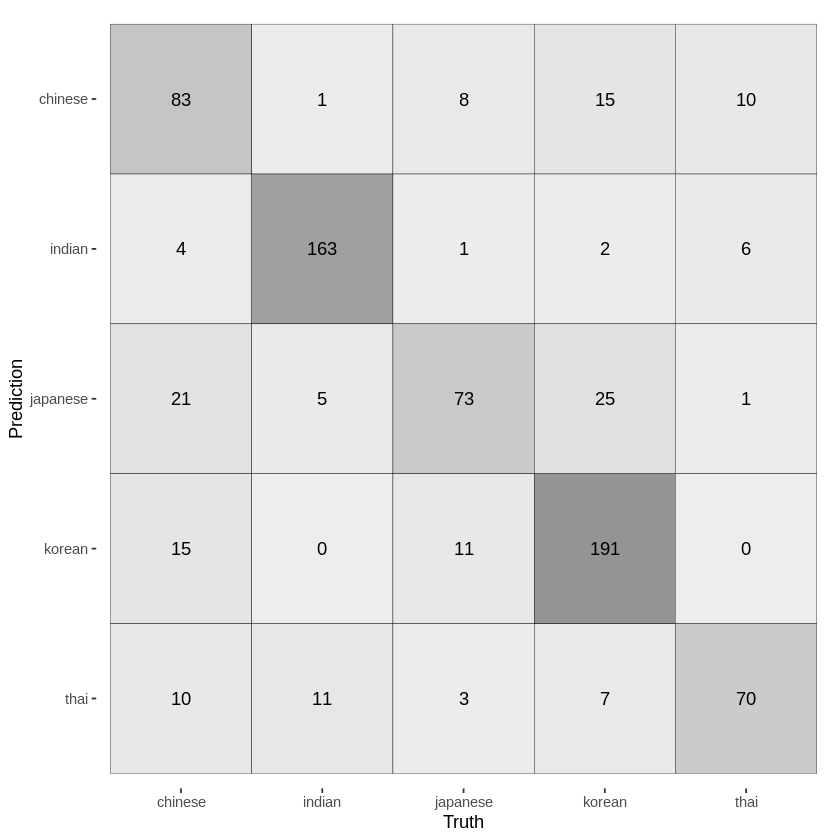

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

المربعات الداكنة في مخطط مصفوفة الالتباس تشير إلى أعداد كبيرة من الحالات، ومن المفترض أن ترى خطًا قطريًا من المربعات الداكنة يشير إلى الحالات التي تكون فيها التسمية المتوقعة والتسمية الفعلية متطابقة.

لنحسب الآن الإحصائيات الملخصة لمصفوفة الالتباس.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

إذا ركزنا على بعض المقاييس مثل الدقة، الحساسية، والقيمة التنبؤية الإيجابية، فنحن لسنا في وضع سيئ كبداية 🥳!

## 4. التعمق أكثر

دعونا نطرح سؤالًا دقيقًا: ما هي المعايير المستخدمة لتحديد نوع معين من المأكولات كالناتج المتوقع؟

حسنًا، تعتمد خوارزميات التعلم الآلي الإحصائي، مثل الانحدار اللوجستي، على `الاحتمالية`. وبالتالي، ما يتم التنبؤ به فعليًا من قبل المصنف هو توزيع احتمالي على مجموعة من النتائج الممكنة. يتم اختيار الفئة ذات الاحتمالية الأعلى كالناتج الأكثر احتمالًا بناءً على الملاحظات المقدمة.

دعونا نرى هذا عمليًا من خلال إجراء تنبؤات صعبة للفئات واحتمالياتها.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ هل يمكنك شرح لماذا النموذج متأكد جدًا أن الملاحظة الأولى تايلاندية؟

## **🚀التحدي**

في هذا الدرس، استخدمت بياناتك المنظفة لبناء نموذج تعلم آلي يمكنه التنبؤ بالمطبخ الوطني بناءً على سلسلة من المكونات. خذ بعض الوقت لقراءة [الخيارات العديدة](https://www.tidymodels.org/find/parsnip/#models) التي توفرها Tidymodels لتصنيف البيانات و[طرق أخرى](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) لتطبيق الانحدار متعدد الحدود.

#### شكر خاص إلى:

[`أليسون هورست`](https://twitter.com/allison_horst/) على إنشاء الرسوم التوضيحية الرائعة التي تجعل R أكثر ترحيبًا وجاذبية. يمكنك العثور على المزيد من الرسوم التوضيحية في [معرضها](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[كاسي بريفيو](https://www.twitter.com/cassieview) و[جين لوبر](https://www.twitter.com/jenlooper) على إنشاء النسخة الأصلية من هذا الوحدة بلغة بايثون ♥️

<br>
كنت سأضيف بعض النكات لكنني لا أفهم التلاعب بالكلمات المتعلقة بالطعام 😅.

<br>

تعلم سعيد،

[إريك](https://twitter.com/ericntay)، سفير طلاب مايكروسوفت للتعلم الذهبي.



---

**إخلاء المسؤولية**:  
تمت ترجمة هذا المستند باستخدام خدمة الترجمة الآلية [Co-op Translator](https://github.com/Azure/co-op-translator). بينما نسعى لتحقيق الدقة، يرجى العلم أن الترجمات الآلية قد تحتوي على أخطاء أو معلومات غير دقيقة. يجب اعتبار المستند الأصلي بلغته الأصلية هو المصدر الموثوق. للحصول على معلومات حساسة أو هامة، يُوصى بالاستعانة بترجمة بشرية احترافية. نحن غير مسؤولين عن أي سوء فهم أو تفسيرات خاطئة تنشأ عن استخدام هذه الترجمة.
